In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

print(Measurement)
print(Station)

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"The most recent date in the data set is: {recent}")

The most recent date in the data set is: 2017-08-23


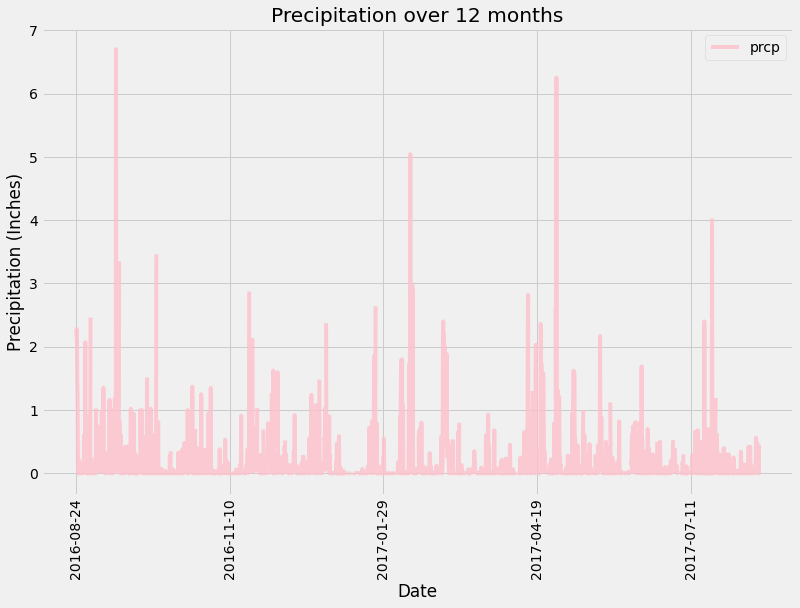

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
plus_1yr = dt.datetime.strptime(recent, '%Y-%m-%d') - dt.timedelta(days = 365)
plus_1yr

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= plus_1yr).all()
precipitation

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precipitation).set_index('date')
precip_df.head()

# Sort the dataframe by date
precip_df = precip_df.sort_index(ascending = True)
precip_df

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(
    rot = 90,
    alpha = 0.8,
    color = 'pink',
    figsize = (12, 8)
    )
plt.title('Precipitation over 12 months')
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.show()



In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
total_number_stations = session.query(Station).count()
total_number_stations

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations_query = session.query(Measurement.station, Measurement.date).all()
most_active_stations_df = pd.DataFrame(most_active_stations_query, columns = ['station', 'frequency'])

most_active_stations_df = most_active_stations_df.groupby(['station']).count().sort_values('frequency', ascending = False )
most_active_stations_df

,frequency
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations_df.index[0]

# Code to find name of most active station
most_active_station_df1 = pd.DataFrame(session.query(
    Station.station, 
    Station.name
    ).filter(Station.station == most_active_station
        ).all(), 
        columns = ["station",  "name"])

most_active_station_name =  most_active_station_df1.loc[0, "name"]

print(f"The most active station is {most_active_station_name}. The station ID is: {most_active_station}. The temperature summary:")

most_active_station_temps = session.query(
      Measurement.station, 
      Measurement.date, 
      Measurement.tobs).filter(
            Measurement.station == most_active_station
            ).all()
most_active_station_temps_df = pd.DataFrame(most_active_station_temps, columns = ['station', 'date', 'tobs'])
most_active_station_temps_df

The most active station is WAIHEE 837.5, HI US. The station ID is: USC00519281. The temperature summary:


,station,date,tobs
0,USC00519281,2010-01-01,70.0
1,USC00519281,2010-01-02,62.0
2,USC00519281,2010-01-03,74.0
3,USC00519281,2010-01-04,75.0
4,USC00519281,2010-01-05,74.0
...,...,...,...
2767,USC00519281,2017-08-14,77.0
2768,USC00519281,2017-08-15,77.0
2769,USC00519281,2017-08-16,76.0
2770,USC00519281,2017-08-17,76.0


In [15]:
USC00519281_calc = [Measurement.station, 
      func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)
      ]
USC00519281_calc_table = session.query(*USC00519281_calc).filter_by(station = most_active_station).all()
print(USC00519281_calc_table)

print(f"----------------------------\n\
Temperature Analysis\n\
----------------------------\n\
The most active station ID: {most_active_station} - {most_active_station_name}.\n\
Lowest temperature: {USC00519281_calc_table[0][1]},\n\
Highest temperature: {USC00519281_calc_table[0][2]},\n\
Average temperature: {USC00519281_calc_table[0][3]}")

[('USC00519281', 54.0, 85.0, 71.66378066378067)]
----------------------------
Temperature Analysis
----------------------------
The most active station ID: USC00519281 - WAIHEE 837.5, HI US.
Lowest temperature: 54.0,
Highest temperature: 85.0,
Average temperature: 71.66378066378067


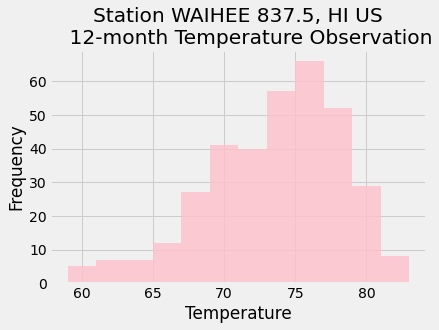

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_date = dt.datetime.strftime(plus_1yr, '%Y-%m-%d')

# active_station_year = session.query(
#     Measurement.date, 
#     Measurement.tobs
#     ).filter_by(station = most_active_station
#     ).filter(Measurement.date >= year_date).all()

# USC00519281_df = pd.DataFrame(active_station_year)

    # Query the last 12 months
last_12m_df = most_active_station_temps_df.loc[(most_active_station_temps_df.date > year_date)]

plt.hist(
    last_12m_df['tobs'].tolist(), 
    bins = 12,
    alpha = 0.8,
    color = 'pink'
    )
plt.title(f'Station {most_active_station_name}\n\
    12-month Temperature Observation')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

    # rot = 90,
    # alpha = 0.8,
    # color = 'pink',
    # figsize = (12, 8)

# Close session

In [17]:
# Close Session
session.close()